In [675]:
import numpy as np  # NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt  # For plotting
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
import networkx as nx



In [735]:
from faker import spatial
from faker import graph

In [736]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [737]:
import logging
logging.basicConfig(level=logging.INFO)

In [738]:
bbox = np.array([[0,0],[100,100]])

In [751]:
centres = spatial.Centres(bbox, density = 0.001)
centres

13 centres

(-4.958162184922888,
 104.73842522648208,
 -2.7475020422528815,
 97.40524852776947)

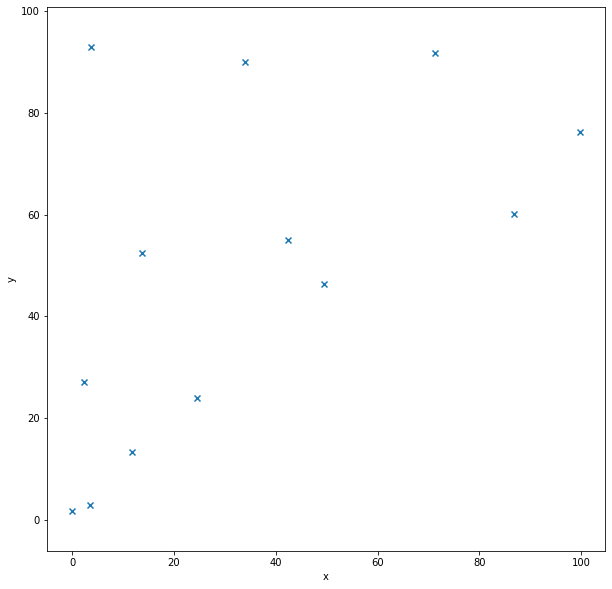

In [752]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(centres.x, centres.y, alpha=1, marker='x')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

In [759]:
hhs = spatial.Clusters(centres, size=10000, sigma=10)
hhs

9988 units, 13 centres

In [760]:
offices = spatial.Clusters(centres, size=500, sigma=5)
offices

494 units, 13 centres

In [761]:
leisure = spatial.Clusters(centres, size=500, sigma=8)
leisure

527 units, 13 centres

In [762]:
education = spatial.Clusters(centres, size=200, sigma=8)
education

235 units, 13 centres

In [763]:
health = spatial.Clusters(centres, size=10, sigma=8)
health

13 units, 13 centres

(-41.64485841335491,
 138.72292950608147,
 -35.53279407037998,
 135.02514578357264)

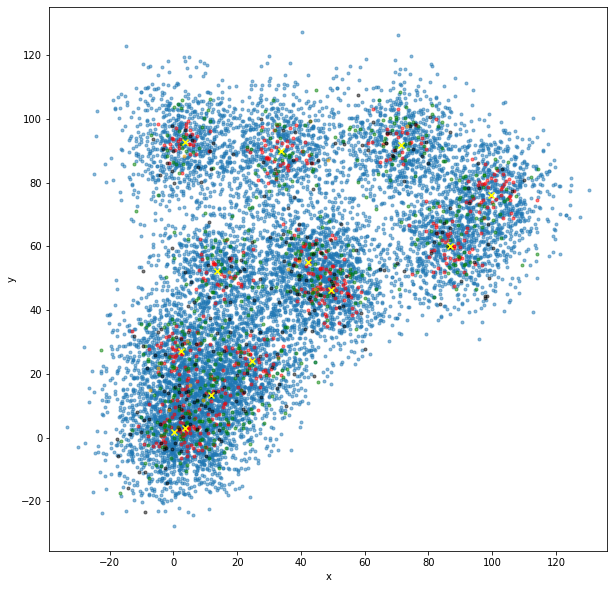

In [764]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(hhs.x, hhs.y, alpha=0.5, marker='.')
ax.scatter(offices.x, offices.y, alpha=0.5, marker='.', c='r')
ax.scatter(leisure.x, leisure.y, alpha=0.5, marker='.', c='g')
ax.scatter(education.x, education.y, alpha=0.5, marker='.', c='black')
ax.scatter(health.x, health.y, alpha=0.5, marker='.', c='orange')
ax.scatter(centres.x, centres.y, alpha=1, marker='x', c='yellow')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

In [765]:
# adjust bbox
bbox = hhs.bbox
bbox

array([[-33.44363443, -27.77740106],
       [130.52170552, 127.26975277]])

In [766]:
pop_size = hhs.len
pop_size

9988

In [767]:
def minmax(array, axis=0):
    if len(array.shape) > 1:
        return (array - array.min(axis=axis)) / (array.max(axis=axis) - array.min(axis=axis))
    else:
        return (array - min(array)) / (max(array) - min(array))

In [768]:
# build some hidden features for households

In [769]:
# points
hh_locs = [Point(x, y) for x, y in zip(hhs.x,hhs.y)]
centres_locs = [Point(x, y) for x, y in zip(centres.x, centres.y)]
hh_centres = [Point(x, y) for x, y in zip(hhs.cx, hhs.cy)]

hh_dist_to_centre = np.array([x.distance(y) for x, y in zip(hh_locs, hh_centres)])
hh_dist_to_centre_mm = minmax(hh_dist_to_centre)

In [770]:
# centres tree
tree = KDTree(centres.locs)

dist_closest_centre, _ = tree.query(hhs.locs, dualtree=True, k=1)
dist_closest_centre = dist_closest_centre.reshape(-1)
hh_dist_closest_centre_mm = minmax(dist_closest_centre)

nearest_dist, _ = tree.query(hhs.locs, dualtree=True, k=3)
dist_closest_centres = nearest_dist.sum(axis=1)
hh_dist_closest_centres_mm = minmax(dist_closest_centres)

In [771]:
# hh locations tree
tree = KDTree(hhs.locs)
density = tree.query_radius(hhs.locs, count_only=True, r=1)
hh_density_mm = minmax(density)

In [772]:
hh_locs_mm = minmax(hhs.locs)
hh_centre_ids_mm = minmax(hhs.ids)

In [773]:
# build some attributes based on these hidden features and on each other

In [774]:
def gen_hidden(xx, yy, hh_density_mm):
    """
    hidden household variable
    """
    p1 = np.random.poisson(xx*10)
    p2 = np.random.poisson(hh_density_mm*10)
    p3 = np.random.poisson(hh_density_mm*xx*10)
    p4 = np.random.poisson(((xx - .5)*10)**2)
    p5 = np.random.poisson(yy*10)
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [775]:
def gen_hh_count(hidden, density):
    """
    num people in household
    """
    p1 = density*50 + hidden*2
    p2 = density*40 + hidden*4
    p3 = density*30 + hidden*6
    p4 = density*20 + hidden*8
    p5 = density*10 + hidden*10
    choice = np.array([p1,p2,p3,p4,p5])
    choice = choice/sum(choice)
    return np.random.choice([1,2,3,4,5], p=choice)

In [776]:
hh_hidden = np.array([gen_hidden(x,y,d) for (x,y),d in zip(hh_locs_mm, hh_density_mm)])
hh_count = np.array([gen_hh_count(e,d) for e,d in zip(hh_hidden, hh_density_mm)])


In [777]:
def gen_num_children(count, hidden, hh_dist_closest_centre_mm):
    """
    1 person = a
    2 persons = aa, ac
    3 persons = aaa, aac, acc
    4 people = aaaa, aaac, aacc, accc
    5 people = aaaaa, aaaac, aaacc, aaccc, acccc
    
    """
    if count == 1:
        return 0
    
    else:
        pchild = hh_dist_closest_centre_mm * count / 2
        padult = hidden / 5
        p = pchild / (pchild + padult)
        return np.random.binomial((count - 1), p, size=None)

In [778]:
hh_children = np.array([gen_num_children(c,h,d) for c,h,d in zip(hh_count, hh_hidden, hh_dist_closest_centre_mm)])

In [779]:
sum(hh_count)

33242

In [780]:
sum(hh_children)

10615

In [781]:
def gen_age_group(hh_children, hh_hidden, hh_density_mm):
    
    if hh_children:
        return int(np.random.uniform(16, 16 + hh_hidden) + np.random.triangular(0, 3 * hh_hidden, 20))
    
    old = 50 + (2*hh_hidden)
    adult = 30 + (2*hh_hidden)
    return np.random.choice(
        [
            int(np.random.poisson(old)),
            int(np.random.poisson(adult)),
        ],
        p=(1-hh_density_mm, hh_density_mm)
    )

In [782]:
hh_age_group = np.array([gen_age_group(c,h,d) for c,h,d in zip(hh_children, hh_hidden, hh_density_mm)])

In [783]:
def get_income(hh_dist_closest_centres_mm, hh_density_mm):
    return (15 + np.random.poisson(5*(hh_dist_closest_centres_mm + 1 - hh_density_mm))*5)*1000

In [784]:
hh_income = np.array([get_income(d, s) for d, s in zip(hh_dist_closest_centres_mm, hh_density_mm)])
hh_income_mm = minmax(hh_income)

In [785]:
def get_cars(hh_hidden, income_mm, density_mm, hh_count, hh_children):
    adults = hh_count - hh_children
    p1 = income_mm * (1 - density_mm)
    if hh_hidden < 3:
        p1 /=2
    p2 = p1 / 2
    return np.random.binomial(1, p1) + np.random.binomial(adults-1, p2)

In [786]:
hh_cars = np.array([get_cars(a,b,c,d,e) for a,b,c,d,e in zip(hh_hidden, hh_income_mm, hh_density_mm, hh_count, hh_children)])

In [787]:
from faker.tree import RegularBlock

In [788]:
hh_indexes = np.array(range(len(hhs.locs)))
hh_indexes.shape

(9988,)

In [789]:
hhs.locs.shape

(9988, 2)

In [790]:

data = np.zeros((hhs.len, 3))
data[:,0] = hh_indexes
data[:,1:] = hhs.locs
hh_locs_array.shape

(1459, 3)

In [791]:
grid = RegularBlock(bbox=bbox, data=data, max_points=500)

In [792]:
geom_data = []
geom_maps = []
G = nx.DiGraph()
idx = 0

for block in grid.traverse():
    
    if block.leaf:
        geom_data.append({'block_id': idx, 'density': block.density(), 'geometry': block.district()})
        geom_maps.append(block.build_point_data(idx))
        
    block.build_block_net(idx, G)
    
    idx += 1
        
hh_grid_ids = np.concatenate(geom_maps)
hh_grid_ids = hh_grid_ids[hh_grid_ids[:,0].argsort()]
hh_grid_ids = hh_grid_ids[:,1]

In [793]:
block_df = pd.DataFrame(geom_data)
block_gdf = gpd.GeoDataFrame(block_df, geometry='geometry')

block_gdf.head()

,block_id,density,geometry
0,3,0.045314,"POLYGON ((-33.44363 -27.77740, -12.94797 -27.7..."
1,4,0.198880,"POLYGON ((-33.44363 -8.39651, -12.94797 -8.396..."
2,6,1.067407,"POLYGON ((-12.94797 -8.39651, -2.70013 -8.3965..."
3,7,1.621250,"POLYGON ((-12.94797 1.29394, -2.70013 1.29394,..."
4,8,3.000823,"POLYGON ((-2.70013 1.29394, 7.54770 1.29394, 7..."


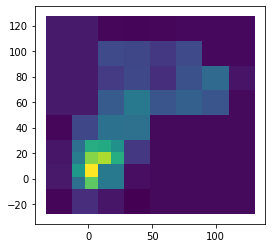

In [794]:
block_gdf.plot(column='density')

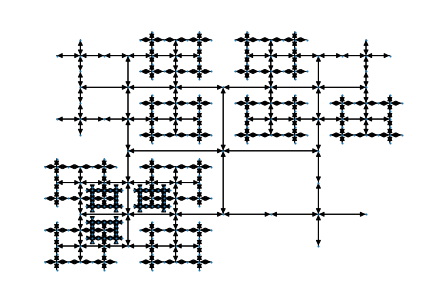

In [795]:
pos = {k: v['pos'] for k, v in G.nodes.items()}
nx.draw(G, pos=pos, node_size=1)

In [796]:
ods = graph.NodesOD(G)

In [797]:
ods.od.shape

(325, 325)

In [279]:
# assemble hh variables            
hh_array = np.stack(
    [
        hh_indexes,
        hh_grid_ids,
        centre_ids,
        hh_dist_to_centre_mm,
        hh_dist_closest_centres_mm,
        hh_density_mm,
        hh_hidden,
        hh_count,
        hh_children,
        hh_age_group,
    ]
, axis=1)

In [280]:
hh_array.shape

(1459, 10)

In [281]:
agent_hh_array = np.repeat(hh_array, hh_count, axis=0)

In [282]:
agent_hh_array.shape

(5088, 10)

In [283]:
agent_index = np.array(range(len(agent_hh_array)))

In [284]:
# get ident for each agent in hh
# _, _, counts = np.unique(sorted_records_array, return_counts=True, return_index=True)
agent_hh_index = np.array([i for c in hh_count for i in range(c)])

In [285]:
agent_hh_index.shape

(5088,)

In [286]:
def get_is_adult(agent_hh_index, hh_array):
    num_children = hh_array[-2]
    if agent_hh_index < num_children:
        return 0
    else:
        return 1

In [287]:
agent_is_adult = np.array([get_is_adult(i,c) for i,c in zip(agent_hh_index, agent_hh_array)])

In [288]:
agent_is_adult.shape

(5088,)

In [289]:
def get_gender(agent_hh_index, agent_hh_array, agent_is_adult):
    
    if not agent_is_adult:
        pman=.49
        return np.random.choice([0, 1], p=[pman, 1-pman])
    
    elif agent_hh_array[-1]:  # number of children
        number_adults = agent_hh_array[-3] - agent_hh_array[-2]
        adult_index = agent_hh_index - agent_hh_array[-2]
        p = agent_hh_array[-4] / 10 # hidden hh
        if adult_index % 2:
            return np.random.choice([0, 1], p=[1 - p, p])
        else:
            return np.random.choice([0, 1], p=[p, 1-p])
    else:
        return np.random.choice([0, 1], p=[.48, .52])
        

In [290]:
agent_genders = np.array([get_gender(i,c,a) for i,c,a in zip(agent_hh_index, agent_hh_array, agent_is_adult)])

In [291]:
agent_genders

array([1, 1, 0, ..., 1, 0, 1])

In [292]:
def get_age(agent_hh_array, agent_is_adult):
    
    hh_hidden = agent_hh_array[-4]
    hh_age_group = agent_hh_array[-1]
    
    if not agent_is_adult:
        return int(np.random.uniform(0, 11) + np.random.triangular(0, hh_hidden, 6))
    
    return hh_age_group + int(np.random.poisson(2))
    

In [293]:
agent_ages = np.array([get_age(i,c) for i,c in zip(agent_hh_array, agent_is_adult)])

In [ ]:
def get_dist_pt(dist_closest_centre):
    return np.random.normal(1-dist_closest_centre)**2

In [ ]:
dist_pt = np.array([get_dist_pt(d) for d in dist_closest_centre])

In [ ]:
income = np.array([get_income(d) for d in dist_closest_centres_mm])

In [ ]:
income_mm = minmax(income)

In [ ]:
def get_car(ethnicity, income_mm, density_mm):
    p = income_mm * (1 - density_mm)
    if ethnicity < 3:
        p /=2 
    choice = np.array([p, 1-p])
    return np.random.choice([1, 0], p=choice)

In [ ]:
has_car = np.array([get_car(e, i, d) for e, i, d in zip(ethnicity, income_mm, density_mm)])

In [ ]:
# build df

In [ ]:
data_dict =  {
        'x': xx,
        'y': yy,
        'centre_id': centre_ids,
        'dist_centre': dist_to_centre,
        'density': density,
        'gender': genders,
        'ethnicity': ethnicity,
        'hh_people': hh_people,
        'age': age,
        'dist_pt': dist_pt,
        'income': income,
        'has_car': has_car
    }

In [ ]:
for k,v in data_dict.items():
    print(k, len(v))

In [ ]:
data = pd.DataFrame(data_dict)

In [ ]:
data.head()

In [ ]:
data.to_csv('data.csv', index=False)